In [1]:
%load_ext autoreload
%autoreload 2
from alphatoe import models, plot, interpretability, game
import pandas as pd
import torch
from pytorch_memlab import LineProfiler, MemReporter
from showmethetypes import SMTT
import einops
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
import numpy as np
import tqdm
import random

In [2]:
tt = SMTT()

In [3]:
games = game.generate_all_games([game.Board()])

In [4]:
five_move_games = torch.stack(
    [
        torch.tensor([10] + game.moves_played)
        for game in games
        if len(game.moves_played) == 5
    ]
)

In [5]:
five_move_games

tensor([[10,  0,  1,  3,  2,  6],
        [10,  0,  1,  3,  4,  6],
        [10,  0,  1,  3,  5,  6],
        ...,
        [10,  8,  7,  5,  3,  2],
        [10,  8,  7,  5,  4,  2],
        [10,  8,  7,  5,  6,  2]])

In [6]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [7]:
autoenc = models.SparseAutoEncoder(512, 1024).cuda()
autoenc.load_state_dict(
    torch.load("./sparse_autoencoder_on_activations_07NOV2023_parameters.pt")
)

<All keys matched successfully>

In [8]:
def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [9]:
activations = autoenc.get_activations(neuron_activations(five_move_games))[:, -1]

In [10]:
tt(activations)

Tensor (dtype: torch.float32)
    │   (device: cuda:0)
    ├── dim_0 (1440)
    └── dim_1 (1024)


In [11]:
"""
if act on 995 > 0 and 600 == 0 or vice versa, keep game
"""

on_995 = []
on_600 = []
on_both = []
for i in range(activations.shape[0]):
    if activations[i][995] > 0.5 and activations[i][600] == 0:
        on_995.append(i)
    elif 0 <= activations[i][600] < 2 and activations[i][995] == 0:
        on_600.append(i)
    elif activations[i][600] > 2 and activations[i][995] > 0.5:
        on_both.append(i)

In [12]:
on_both

[5,
 6,
 7,
 8,
 9,
 15,
 16,
 17,
 18,
 19,
 25,
 26,
 27,
 28,
 29,
 35,
 36,
 37,
 38,
 39,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 95,
 96,
 97,
 98,
 99,
 105,
 106,
 107,
 108,
 109,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 145,
 146,
 147,
 148,
 149,
 155,
 156,
 157,
 158,
 159,
 305,
 306,
 307,
 308,
 309,
 315,
 316,
 317,
 318,
 319,
 325,
 326,
 327,
 328,
 329,
 335,
 336,
 337,
 338,
 339,
 355,
 356,
 357,
 358,
 359,
 365,
 366,
 367,
 368,
 369,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 445,
 446,
 447,
 448,
 449,
 455,
 456,
 457,
 458,
 459,
 630,
 631,
 632,
 633,
 634,
 655,
 656,
 657,
 658,
 659,
 660,
 661,
 662,
 663,
 664,
 685,
 686,
 687,
 688,
 689,
 690,
 691,
 692,
 693,
 694,
 715,
 716,
 717,
 718,
 719,
 720,
 721,
 722,
 723,
 724,
 745,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 753,
 754,
 775,
 776,
 777,
 778,
 779,
 780,
 781,
 782,
 7

In [13]:
for i, j, k in zip(on_995, on_600, on_both):
    # print("995")
    # game.play_game(list(five_move_games[i]))
    # print("600")
    # game.play_game(list(five_move_games[j]))
    print("both")
    game.play_game(list(five_move_games[k]))

both
| X | O | O |
|   | X |   |
|   |   | X |
both
| X | O |   |
| O | X |   |
|   |   | X |
both
| X | O |   |
|   | X | O |
|   |   | X |
both
| X | O |   |
|   | X |   |
| O |   | X |


In [14]:
for i in on_600:
    print()
    game.play_game(list(five_move_games[i]))


| X | O | O |
| X |   |   |
| X |   |   |

| X | O |   |
| X | O |   |
| X |   |   |

| X | O |   |
| X |   | O |
| X |   |   |

| X | O |   |
| X |   |   |
| X | O |   |

| X | O | O |
| X |   |   |
| X |   |   |

| X | O |   |
| X | O |   |
| X |   |   |

| X | O |   |
| X |   | O |
| X |   |   |

| X | O |   |
| X |   |   |
| X | O |   |

| X | O | O |
| X |   |   |
| X |   |   |

| X |   | O |
| X | O |   |
| X |   |   |

| X |   | O |
| X |   | O |
| X |   |   |

| X |   | O |
| X |   |   |
| X | O |   |

| X |   | O |
| X |   |   |
| X |   | O |

| X | O | O |
| X |   |   |
| X |   |   |

| X |   | O |
| X | O |   |
| X |   |   |

| X |   | O |
| X |   | O |
| X |   |   |

| X |   | O |
| X |   |   |
| X | O |   |

| X |   | O |
| X |   |   |
| X |   | O |

| X | X | X |
| O | O |   |
|   |   |   |

| X | X | X |
| O |   | O |
|   |   |   |

| X | X | X |
| O |   |   |
| O |   |   |

| X | X | X |
| O |   |   |
|   | O |   |

| X | X | X |
| O |   |   |
|   |   | O |

| X | X | 

In [15]:
for i in on_both:
    print()
    game.play_game(list(five_move_games[i]))


| X | O | O |
|   | X |   |
|   |   | X |

| X | O |   |
| O | X |   |
|   |   | X |

| X | O |   |
|   | X | O |
|   |   | X |

| X | O |   |
|   | X |   |
| O |   | X |

| X | O |   |
|   | X |   |
|   | O | X |

| X | O | O |
|   | X |   |
|   |   | X |

| X | O |   |
| O | X |   |
|   |   | X |

| X | O |   |
|   | X | O |
|   |   | X |

| X | O |   |
|   | X |   |
| O |   | X |

| X | O |   |
|   | X |   |
|   | O | X |

| X | O | O |
|   | X |   |
|   |   | X |

| X |   | O |
| O | X |   |
|   |   | X |

| X |   | O |
|   | X | O |
|   |   | X |

| X |   | O |
|   | X |   |
| O |   | X |

| X |   | O |
|   | X |   |
|   | O | X |

| X | O | O |
|   | X |   |
|   |   | X |

| X |   | O |
| O | X |   |
|   |   | X |

| X |   | O |
|   | X | O |
|   |   | X |

| X |   | O |
|   | X |   |
| O |   | X |

| X |   | O |
|   | X |   |
|   | O | X |

| X | O |   |
| O | X |   |
|   |   | X |

| X |   | O |
| O | X |   |
|   |   | X |

| X |   |   |
| O | X | O |
|   |   | X |

| X |   | 

In [16]:
len(on_both)

540

(array([797.,  66.,  37.,   0.,   0.,   0.,  80.,  96., 266.,  98.]),
 array([0.        , 0.43045694, 0.86091387, 1.29137075, 1.72182775,
        2.15228462, 2.5827415 , 3.01319838, 3.44365549, 3.87411237,
        4.30456924]),
 <BarContainer object of 10 artists>)

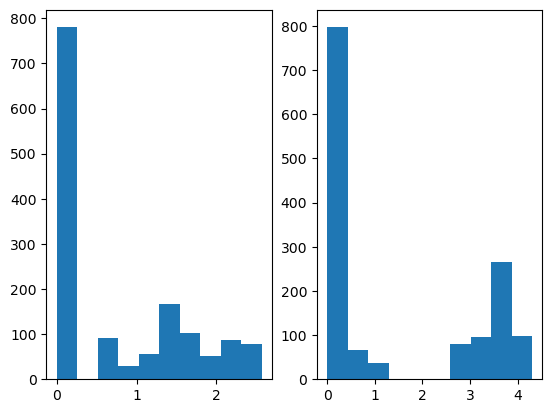

In [17]:
plt.subplot(1, 2, 1)
plt.hist(interpretability.numpy(activations[:, 995]))
plt.subplot(1, 2, 2)
plt.hist(interpretability.numpy(activations[:, 600]))
# activations[:,600]

In [18]:
eight_move_games = torch.stack(
    [
        torch.tensor([10] + game.moves_played)
        for game in games
        if len(game.moves_played) == 8
    ]
)

In [19]:
all_moves = []
for move in range(9):
    yes_move = []
    no_move = []
    for game in eight_move_games:
        if move in game:
            yes_move.append(game)
        elif move not in game:
            no_move.append(game)
    all_moves.append([yes_move, no_move])

In [20]:
for i, l in enumerate(all_moves):
    print(f"move {i} present in {len(l[0])}", len(l[1]))

move 0 present in 65232 7344
move 1 present in 63072 9504
move 2 present in 65232 7344
move 3 present in 63072 9504
move 4 present in 67392 5184
move 5 present in 63072 9504
move 6 present in 65232 7344
move 7 present in 63072 9504
move 8 present in 65232 7344


In [21]:
eight_move_present_or_not_games = torch.cat(
    [
        torch.cat(
            [
                torch.stack([torch.tensor(g) for g in l[0][:5000]]),
                torch.stack([torch.tensor(g) for g in l[1][:5000]]),
            ]
        )
        for l in all_moves
    ]
)

/tmp/ipykernel_69986/3878011079.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.stack([torch.tensor(g) for g in l[0][:5000]]),
/tmp/ipykernel_69986/3878011079.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.stack([torch.tensor(g) for g in l[1][:5000]]),


In [22]:
tt(eight_move_present_or_not_games)

Tensor (dtype: torch.int64)
    │   (device: cpu)
    ├── dim_0 (90000)
    └── dim_1 (9)


In [23]:
# acts = autoenc.get_activations(neuron_activations(eight_move_present_or_not_games))

In [24]:
# tt(acts)

In [25]:
# assert false

In [26]:
act = einops.rearrange(
    autoenc.get_activations(neuron_activations(eight_move_present_or_not_games))[:, -1],
    "(move games) dim -> move games dim",
    move=9,
)

In [29]:
tt(act)

Tensor (dtype: torch.float32)
    │   (device: cuda:0)
    ├── dim_0 (9)
    ├── dim_1 (10000)
    └── dim_2 (1024)


In [33]:
non_zero_acts = act[:, :, act.max(0).values.max(0).values > 0]

In [34]:
tt(non_zero_acts)

Tensor (dtype: torch.float32)
    │   (device: cuda:0)
    ├── dim_0 (9)
    ├── dim_1 (10000)
    └── dim_2 (147)


(array([797.,  66.,  37.,   0.,   0.,   0.,  80.,  96., 266.,  98.]),
 array([0.        , 0.43045694, 0.86091387, 1.29137075, 1.72182775,
        2.15228462, 2.5827415 , 3.01319838, 3.44365549, 3.87411237,
        4.30456924]),
 <BarContainer object of 10 artists>)

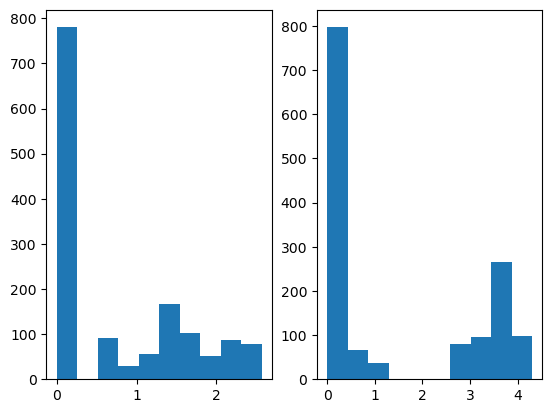

In [27]:
plt.subplot(1, 2, 1)
plt.hist(interpretability.numpy(activations[:, 995]))
plt.subplot(1, 2, 2)
plt.hist(interpretability.numpy(activations[:, 600]))

In [28]:
"""
- Clean up dead neurons
- Make 9 even split plots containing a bunch of games with and without particular moves
"""

'\n- Clean up dead neurons\n- Make 9 even split plots containing a bunch of games with and without particular moves\n'

([<matplotlib.axis.XTick at 0x7fb07b3bf0a0>,
 [Text(2500, 0, 'move present'), Text(7500, 0, 'move not present')])

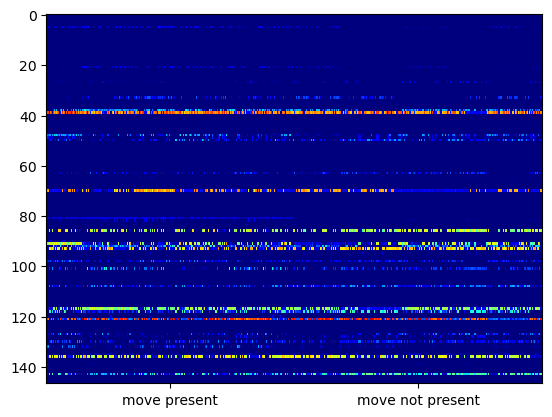

In [52]:
# plt.subplot(9,1, 1)
plt.imshow(
    interpretability.numpy(non_zero_acts[0]).T,
    cmap="jet",
    aspect="auto",
    interpolation="none",
)
plt.xticks(ticks=[2500, 7500], labels=["move present", "move not present"])
# plt.subplot(9,1, 2)
# plt.imshow(non_zero_acts[1], cmap="jet", aspect="auto", interpolation="none")
# plt.subplot(9,1, 3)
# plt.imshow(non_zero_acts[2], cmap="jet", aspect="auto", interpolation="none")